In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import pymc3 as pm

In [7]:
def data_loader_main(data):
    data = pd.read_table(data, sep = '\t', header=None)
    data.columns = ["userid", "itemid", "rating", "timestamp"]
    
    num_users = data['userid'].unique().shape[0]
    num_movies = data['itemid'].unique().shape[0]
    
    rating = np.zeros((num_users, num_movies))
    
    for row in data.itertuples():
        rating[row[1]-1, row[2]-1] = row[3]
    
    return rating, num_users, num_movies

# To get overall matrix in validation set, we get num_users, num_movies as inputs
def data_loader_val(data, num_users, num_movies):
    data = pd.read_table(data, sep = '\t', header=None)
    data.columns = ["userid", "itemid", "rating", "timestamp"]
    
    rating = np.zeros((num_users, num_movies))
    
    for row in data.itertuples():
        rating[row[1]-1, row[2]-1] = row[3]
    
    return rating

In [6]:
data = pd.read_table('./ml-100k/u.data',sep='\t', header=None)
data.columns = ["userid", "itemid", "rating", "timestamp"]

users = pd.read_table('./ml-100k/u.user',sep='|', header=None)
users.columns = ["userid", "age", "gender", "occupation", "zip code"]

movies = pd.read_table('./ml-100k/u.item',sep='|', header=None,  encoding = 'ISO-8859-1')
movies.columns = ["movie id", "movie title", "release date", "video release date", "IMDb URL", "unknown", "Action", "Adventure",
            "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", 
            "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
movies.set_index('movie id', inplace=True)

genre = pd.read_table('./ml-100k/u.genre',sep='|', header=None)
genre.columns = ["genre", "number"]

occupation = pd.read_table('./ml-100k/u.occupation',sep='|', header=None)
occupation.columns = ["ocuupation"]


FileNotFoundError: [Errno 2] File b'../ml-100k/u.data' does not exist: b'../ml-100k/u.data'

In [4]:
data.head()

,userid,itemid,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
movies.head()

,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


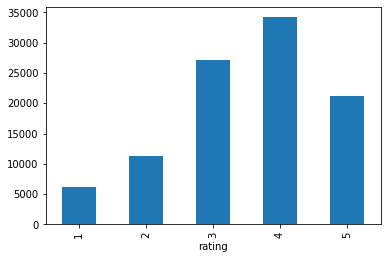

In [6]:
ratings = data.rating

data.groupby("rating").size().plot(kind="bar");

In [7]:
data.rating.describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

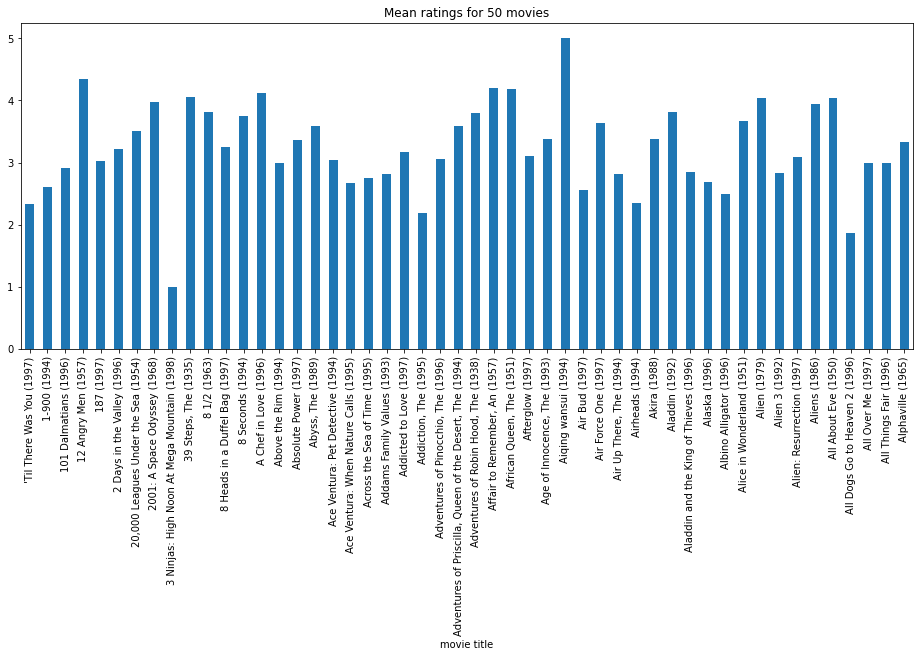

In [8]:
movie_means = data.join(movies['movie title'], on='itemid').groupby('movie title').rating.mean()
movie_means[:50].plot(kind="bar", grid=False, figsize=(16, 6), title="Mean ratings for 50 movies")

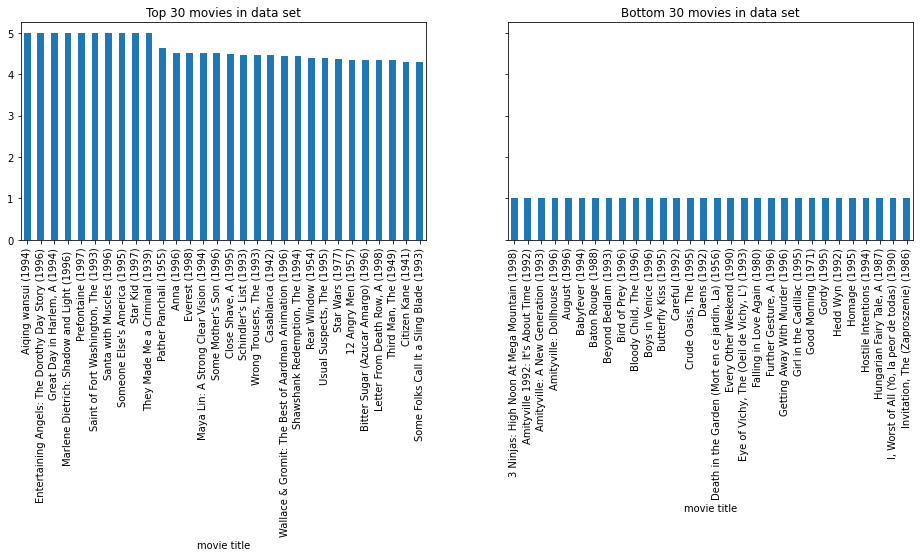

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 4), sharey=True)
movie_means.nlargest(30).plot(kind="bar", ax=ax1, title="Top 30 movies in data set")
movie_means.nsmallest(30).plot(kind="bar", ax=ax2, title="Bottom 30 movies in data set");

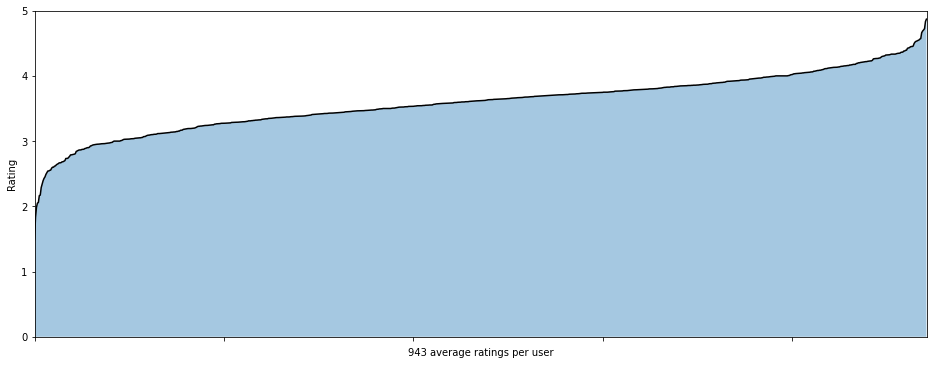

In [10]:
user_means = data.groupby("userid").rating.mean().sort_values()
_, ax = plt.subplots(figsize=(16,6))
ax.plot(np.arange(len(user_means)), user_means.values, 'k-')

ax.fill_between(np.arange(len(user_means)), user_means.values, alpha=0.4)
ax.set_xticklabels("")
ax.set_ylabel("Rating")
ax.set_xlabel(f"{len(user_means)} average ratings per user")
ax.set_ylim(0, 5)
ax.set_xlim(0, len(user_means));

In [11]:
def split_title(title):
    words = []
    tmp = [title[0]]
    for c in title[1:]:
        if c.isupper():
            words.append("".join(tmp))
            tmp = [c]
        else:
            tmp.append(c)
    words.append("".join(tmp))
    return " ".join(words)

class Baseline:
    def __init__(self, train_data):
        self.predict(train_data.copy())
    
    def predict(self, train_data):
        raise NotImplementedError("baseline prediction not implemented for base class")
    
    def rmse(self, test_data):
        return rmse(test_data, self.predicted)
        
    def __str__(self):
        return split_title(self.__class__.__name__)
    
class UniformRandomBaseline(Baseline):
    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        pmin, pmax = masked_train.min(), masked_train.max()
        N = nan_mask.sum()
        train_data[nan_mask] = np.random.uniform(pmin,pmax,N)
        self.predicted = train_data
        
class GlobalMeanBaseline(Baseline):
    def predict(self, train_data):
        nan_mask = np.isnan(train_data)
        train_data[nan_mask] = train_data[~nan_mask].mean()
        self.predicted = train_data
        
class MeanOfMeansBaseline(Baseline):
    def predict(self,train_data):
        nan_mask = np.isnan(train_data)
        masked_train = np.ma.masked_array(train_data, nan_mask)
        global_mean = masked_train.mean()
        user_means = masked_train.mean(axis=1)
        item_means = masked_train.mean(axis=0)
        self.predicted = train_data.copy()
        n, m = train_data.shape
        for i in range(n):
            for j in range(m):
                if np.ma.isMA(item_means[j]):
                    self.predicted[i,j] = np.mean((global_mean, user_means[i]))
                else:
                    self.predicted[i,j] = np.mean((global_mean, user_means[i], item_means[j]))
                    
                    
baseline_methods = {}
baseline_methods["ur"] = UniformRandomBaseline
baseline_methods["gm"] = GlobalMeanBaseline
baseline_methods["mom"] = MeanOfMeansBaseline

In [12]:
num_users = data.userid.unique().shape[0]
num_items = data.itemid.unique().shape[0]
sparsity = 1 - len(data) / (num_users * num_items)
print(f"Users: {num_users}\nMovies: {num_items}\nSparsity: {sparsity}")

dense_data = data.pivot(index="userid", columns="itemid", values="rating").values

Users: 943
Movies: 1682
Sparsity: 0.9369533063577546


In [13]:
import logging
import time

import scipy as sp
import theano

theano.config.compute_test_value = "ignore"

logger = logging.getLogger()
logger.setLevel(logging.INFO)

class PMF:
    def __init__(self, train, dim, alpha=2, std=0.01, bounds=(1,5)):
        self.dim = dim
        self.alpha = alpha
        self.std = np.sqrt(1.0/alpha)
        self.bounds = bounds
        self.data = train.copy()
        n, m = self.data.shape
        
        nan_mask = np.isnan(self.data)
        self.data[nan_mask] = self.data[~nan_mask].mean()
        
        self.alpha_u = 1 / self.data.var(axis=1).mean()
        self.alpha_v = 1 / self.data.var(axis=0).mean()
        
        logging.info("building the PMF model")
        
        with pm.Model() as pmf:
            U = pm.MvNormal(
                "U",
                mu=0,
                tau=self.alpha_u * np.eye(dim),
                shape=(n,dim),
                testval=np.random.randn(n,dim) * std,
            )
            V = pm.MvNormal(
                "V",
                mu=0,
                tau=self.alpha_v * np.eye(dim),
                shape=(m, dim),
                testval=np.random.randn(m, dim) * std,
            )
            R = pm.Normal(
                "R", mu=(U @ V.T)[~nan_mask], tau=self.alpha, observed=self.data[~nan_mask]
            )

        logging.info("done building the PMF model")
        self.model = pmf

    def __str__(self):
        return self.name

In [14]:
def find_map(self):
    """Find mode of posterior using L-BFGS-B optimization."""
    tstart = time.time()
    with self.model:
        logging.info("finding PMF MAP using L-BFGS-B optimization...")
        self._map = pm.find_MAP(method="L-BFGS-B")

    elapsed = int(time.time() - tstart)
    logging.info("found PMF MAP in %d seconds" % elapsed)
    return self._map


def map(self):
    try:
        return self._map
    except:
        return self.find_map()


# Update our class with the new MAP infrastructure.
PMF.find_map = find_map
PMF.map = property(map)

In [15]:
# Draw MCMC samples.
def _draw_samples(self, **kwargs):
    kwargs.setdefault("chains", 1)
    with self.model:
        self.trace = pm.sample(**kwargs)


# Update our class with the sampling infrastructure.
PMF.draw_samples = _draw_samples

In [16]:
##Sigmoid, Constrained 등 추가해서 확장해야할 부분

def predict(self, U, V):
    """Estimate R from the given values of U and V."""
    R = np.dot(U, V.T)
    n, m = R.shape
    sample_R = np.random.normal(R, self.std)
    # bound ratings
    low, high = self.bounds
    sample_R[sample_R < low] = low
    sample_R[sample_R > high] = high
    return sample_R


PMF.predict = predict

In [17]:
# Define our evaluation function.
def rmse(test_data, predicted):
    """Calculate root mean squared error.
    Ignoring missing values in the test data.
    """
    I = ~np.isnan(test_data)  # indicator for missing values
    N = I.sum()  # number of non-missing values
    sqerror = abs(test_data - predicted) ** 2  # squared error array
    mse = sqerror[I].sum() / N  # mean squared error
    return np.sqrt(mse)  # RMSE

In [18]:
# Define a function for splitting train/test data.
def split_train_test(data, percent_test=0.1):
    """Split the data into train/test sets.
    :param int percent_test: Percentage of data to use for testing. Default 10.
    """
    n, m = data.shape  # # users, # movies
    N = n * m  # # cells in matrix

    # Prepare train/test ndarrays.
    train = data.copy()
    test = np.ones(data.shape) * np.nan

    # Draw random sample of training data to use for testing.
    tosample = np.where(~np.isnan(train))  # ignore nan values in data
    idx_pairs = list(zip(tosample[0], tosample[1]))  # tuples of row/col index pairs

    test_size = int(len(idx_pairs) * percent_test)  # use 10% of data as test set
    train_size = len(idx_pairs) - test_size  # and remainder for training

    indices = np.arange(len(idx_pairs))  # indices of index pairs
    sample = np.random.choice(indices, replace=False, size=test_size)

    # Transfer random sample from train set to test set.
    for idx in sample:
        idx_pair = idx_pairs[idx]
        test[idx_pair] = train[idx_pair]  # transfer to test set
        train[idx_pair] = np.nan  # remove from train set

    # Verify everything worked properly
    assert train_size == N - np.isnan(train).sum()
    assert test_size == N - np.isnan(test).sum()

    # Return train set and test set
    return train, test


train, test = split_train_test(dense_data)

In [19]:
# Let's see the results:
baselines = {}
for name in baseline_methods:
    Method = baseline_methods[name]
    method = Method(train)
    baselines[name] = method.rmse(test)
    print("{} RMSE:\t{:.5f}".format(method, baselines[name]))

Uniform Random Baseline RMSE:	1.68391
Global Mean Baseline RMSE:	1.11602
Mean Of Means Baseline RMSE:	1.00766


In [20]:
# We use a fixed precision for the likelihood.
# This reflects uncertainty in the dot product.
# We choose 2 in the footsteps Salakhutdinov
# Mnihof.
ALPHA = 2

# The dimensionality D; the number of latent factors.
# We can adjust this higher to try to capture more subtle
# characteristics of each movie. However, the higher it is,
# the more expensive our inference procedures will be.
# Specifically, we have D(N + M) latent variables. For our
# Movielens dataset, this means we have D(2625), so for 5
# dimensions, we are sampling 13125 latent variables.
DIM = 10


pmf = PMF(train, DIM, ALPHA, std=0.05)

INFO:root:building the PMF model
INFO:root:done building the PMF model


In [46]:
pmf.find_map();

ValueError: invalid number of arguments

In [ ]:
def eval_map(pmf_model, train, test):
    U = pmf_model.map["U"]
    V = pmf_model.map["V"]

    # Make predictions and calculate RMSE on train & test sets.
    predictions = pmf_model.predict(U, V)
    train_rmse = rmse(train, predictions)
    test_rmse = rmse(test, predictions)
    overfit = test_rmse - train_rmse

    # Print report.
    print("PMF MAP training RMSE: %.5f" % train_rmse)
    print("PMF MAP testing RMSE:  %.5f" % test_rmse)
    print("Train/test difference: %.5f" % overfit)

    return test_rmse


# Add eval function to PMF class.
PMF.eval_map = eval_map

In [ ]:
# Evaluate PMF MAP estimates.
pmf_map_rmse = pmf.eval_map(train, test)
pmf_improvement = baselines["mom"] - pmf_map_rmse
print("PMF MAP Improvement:   %.5f" % pmf_improvement)